# Investigating species of hawks

The raw data is collected from the [Stat2Data  R-package](https://github.com/statmanrobin/Stat2Data/tree/master).
It was originally collected by students and faculty at Cornell College in Mount Vernon, Iowa. The data we use here contains a subset of the features, and observations with missing numbers have been removed. The variables are:

* The species: RT (Red-tailed), CH (Cooper's), and SS (Sharp-shinned).
* The age: A (adult) or I (immature).
* The sex: F (female), M (male), or ? (for unknown).
* The length (in mm) of the primary wing feather.
* The body weigth (in g).
* The tail length (in mm).
* The length of the [culmen](https://en.wikipedia.org/wiki/Beak#Culmen) (in mm).

We will use PCA to see if we can group the birds according to the species. But first, we will make a scatter
plot matrix to see what we can learn:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="muted")

data = pd.read_csv("hawks.csv")
data.head()

,Species,Age,Sex,Wing,Weight,Tail,Culmen
0,RT,I,?,385.0,920.0,219,25.7
1,RT,I,?,381.0,990.0,235,26.7
2,CH,I,F,265.0,470.0,220,18.7
3,SS,I,F,205.0,170.0,157,12.5
4,RT,I,?,412.0,1090.0,230,28.5


In [2]:
# The species are:
species = {
    "RT": "Red-tailed hawk",
    "CH": "Cooper's hawk",
    "SS": "Sharp-shinned hawk",
}
data["Species"] = [species[i] for i in data["Species"]]

In [3]:
data.describe()

,Wing,Weight,Tail,Culmen
count,892.000000,892.000000,892.000000,892.000000
mean,316.000224,771.809417,198.914798,21.811939
std,95.276221,462.713462,36.811522,7.289653
min,37.200000,56.000000,119.000000,8.600000
25%,202.000000,185.000000,160.000000,12.800000
50%,370.000000,970.000000,214.000000,25.500000
75%,390.000000,1120.000000,225.000000,27.325000
max,480.000000,2030.000000,288.000000,39.200000


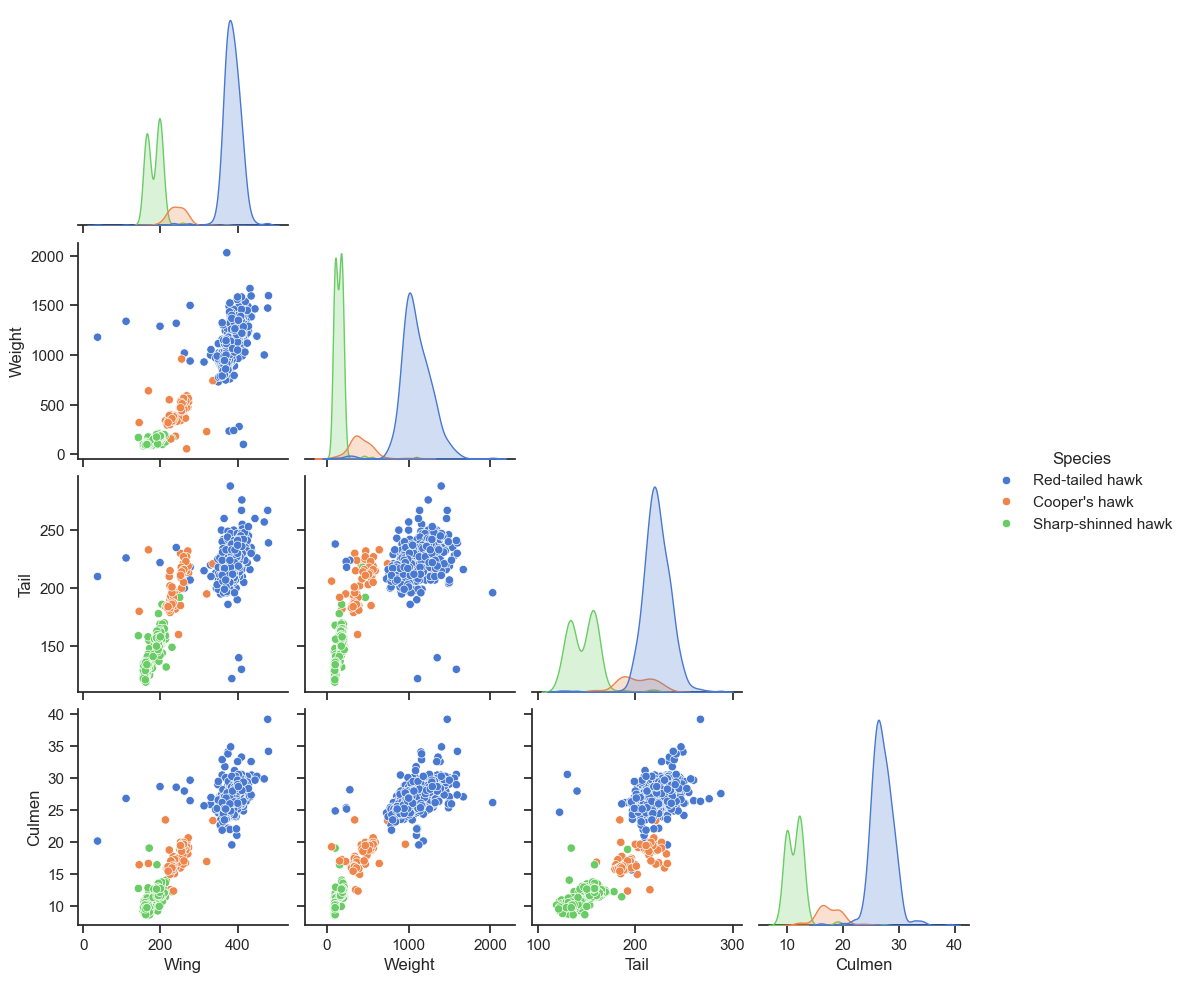

In [4]:
# We first create a scatter plot matrix with seaborn.
# The parameter "hue" is used to select groups we color according to.
grid = sns.pairplot(
    data,
    corner=True,
    hue="Species",
)

# Dimension reduction by Principal component analysis
In this section, we will use principal component analysis to check if we can "discover" the different
species from measured features.

## Preprocessing the data
Before we run the analysis, we preprocess the data since we are using variables with different units:

In [5]:
from sklearn.preprocessing import StandardScaler

variables = ["Wing", "Tail", "Weight", "Culmen"]
scale = StandardScaler().fit(data[variables])
X = scale.transform(data[variables])

## Performing PCA

To run the principal component analysis, we make use of [PCA from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html):

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
scores = pca.fit_transform(X)

## Plotting the new coordinates (scores)

We plot the scores for the first principal component against the scores for the second principal component:

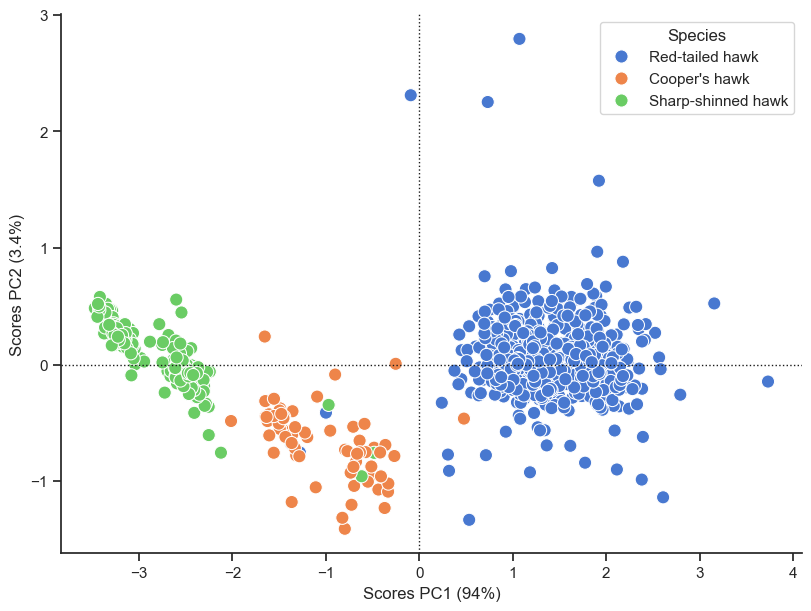

In [7]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))
sns.scatterplot(
    data=data, x=scores[:, 0], y=scores[:, 1], ax=ax, s=90, hue="Species"
)

# The rest of the code here is just to style the plot:
ax.axhline(y=0, ls=":", c="k", lw=1)
ax.axvline(x=0, ls=":", c="k", lw=1)
ax.set(xlabel=f"Scores PC1 ({pca.explained_variance_ratio_[0]*100:.2g}%)")
ax.set(ylabel=f"Scores PC2 ({pca.explained_variance_ratio_[1]*100:.2g}%)")
sns.despine(fig=fig)

## Plotting the loadings

Next, we will investigate the loadings. The loadings explain the new coordinate system. Specifically, they show the transformation from the old axes to the new coordinate system. We can get the loadings by inspecting the PCA object we created above:

In [8]:
loadings = pca.components_.T
loadings

array([[ 0.5034567 ,  0.18765939, -0.75008678, -0.38559709],
       [ 0.48910961, -0.84285486,  0.18369865, -0.12892745],
       [ 0.49940548,  0.4805394 ,  0.63287074, -0.34518208],
       [ 0.5078359 ,  0.15317156, -0.05567089,  0.84589711]])

Each row of `pca.components_` (= each column of the transposed `pca.components_.T`) contains a principal component. The first one is:

In [9]:
pc1 = loadings[:, 0]
print(pc1)

[0.5034567  0.48910961 0.49940548 0.5078359 ]


These numbers define how we construct the principal component:

In [10]:
text = " + ".join([f"{i:4.2f} * {j}" for i, j in zip(pc1, variables)])
print(f"pc1 = {text}")

pc1 = 0.50 * Wing + 0.49 * Tail + 0.50 * Weight + 0.51 * Culmen


Here, the first principal component contains contributions from all the variables and approximately the same amount from each of them. We can also check that it is normalized:

In [11]:
np.linalg.norm(pc1)

1.0

OK, enough about that: It is time to plot the loadings for the first two principal components:

In [12]:
def plot_loadings_arrows(pca, idxi=0, idxj=1, labels=None):
    fig, ax = plt.subplots(constrained_layout=True)

    loadings = pca.components_.T

    load1 = loadings[:, idxi]
    load2 = loadings[:, idxj]

    var1 = pca.explained_variance_ratio_[idxi] * 100
    var2 = pca.explained_variance_ratio_[idxj] * 100

    ax.set(xlabel=f"Loadings PC1 ({var1:.2g}%)")
    ax.set(ylabel=f"Loadings PC2 ({var2:.2g}%)")
    ax.axhline(y=0, ls=":", color="k")
    ax.axvline(x=0, ls=":", color="k")

    ax.scatter(load1, load2, color="none")  # to adjust the axes

    for i in range(pca.n_features_in_):
        x, y = load1[i], load2[i]

        ax.annotate(
            "",
            xy=(x, y),
            xytext=(0, 0),
            arrowprops=dict(
                arrowstyle="-|>", lw=2, color="red", mutation_scale=25
            ),
        )
        txt = f"{i}"
        if labels is not None:
            txt = labels[i]
        ax.text(x, y, txt, fontsize="xx-small")

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    sns.despine(fig=fig)

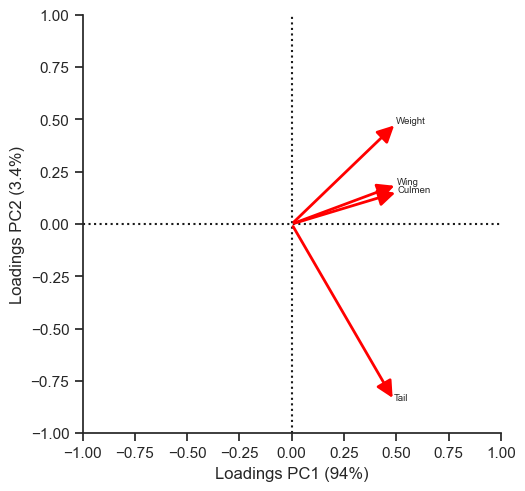

In [13]:
plot_loadings_arrows(pca, idxi=0, idxj=1, labels=variables)

In the plot above, we see, for instance, that the `Wing` and `Culmen` are almost on top of each other. The interpretation is that
  birds with larger wings have larger culmen (or vice versa).

## Explained variance

We can also inspect how much of the variance we are explaining with the principal components:

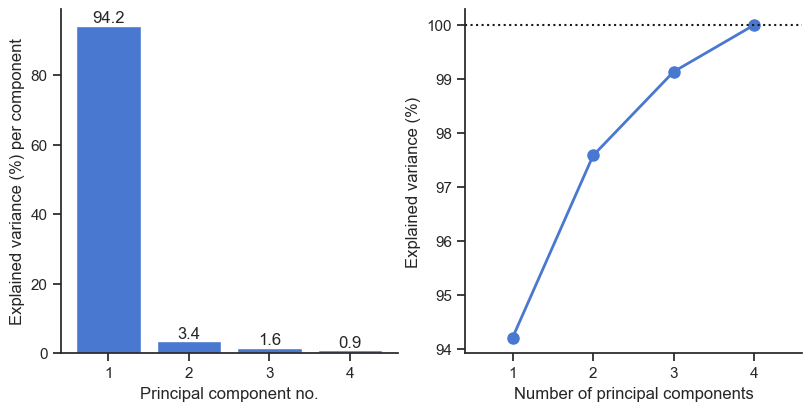

In [14]:
fig, (ax1, ax2) = plt.subplots(
    constrained_layout=True, ncols=2, figsize=(8, 4), sharex=True
)
variance = pca.explained_variance_ratio_
components = 1 + np.arange(len(variance))
bar = ax1.bar(components, variance * 100.0)
ax1.bar_label(bar, fmt="{:.1f}")
ax2.plot(
    components, np.cumsum(variance) * 100.0, marker="o", markersize=8, lw=2
)
ax1.set_xlabel("Principal component no.")
ax1.set_ylabel("Explained variance (%) per component")
ax2.set_xlabel("Number of principal components")
ax2.set_ylabel("Explained variance (%)")
ax2.axhline(y=100, ls=":", color="k")
sns.despine(fig=fig)

In this particular example, we explain most of the variance with the first principal component!